# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv <= 3.4.2`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
import numpy as np
import skimage
import skimage.io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import math
import sys
from PIL import Image

# Helper functions

In [2]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [10]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
#     dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)[:num_matches]
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    return np.hstack((src_pts,dst_pts))

def ransac(data, threshold, iterations, num_samples):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    max_inliers = np.array([], dtype=np.float32)
    best_model_errors = 0
    best_H = []
    idx = np.arange(data.shape[0])
    
    for i in range(iterations):
        np.random.shuffle(idx)
        H = compute_homography(data[idx[:num_samples]])
        
        inliers = []
        error = 0
        for p in data[idx[num_samples:]]:
            out = np.matmul(H, np.array([p[0], p[1], 1]))
            out = out[:2] / out[2]
            e = (out[0] - p[2]) ** 2 + (out[1] - p[3]) ** 2
            
            if e < threshold:
                inliers.append(p)
                error += e
                
        inliers = np.array(inliers)
        if inliers.shape[0] > max_inliers.shape[0]:
            max_inliers = inliers
            best_model_errors = error / inliers.shape[0]
            best_H = H
    
    return max_inliers, best_model_errors, best_H

def compute_homography(samples):
    """
    write your code to compute homography according to the matches
    """
    num_samples = samples.shape[0]
    A = np.zeros((num_samples*2, 9))
    
    for i in range(num_samples):
        lx, ly, rx, ry = samples[i]
        
        A[2*i] = np.array([0, 0, 0, lx, ly, 1, -ry*lx, -ry*ly, -ry], dtype=np.float32)
        A[2*i+1] = np.array([lx, ly, 1, 0, 0, 0, -rx*lx, -rx*ly, -rx], dtype=np.float32)
    
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[len(V) - 1], (3,3))
    return H/H[2, 2]

def warp_images(ax, img1, img2, H):
    """
    write your code to stitch images together according to the homography
    """
    x, y= img2.shape[0:2]
    transform = skimage.transform.ProjectiveTransform(H)
    
    corner = np.array([[0, 0], [0, x], [y, 0], [y, x]])
    corner = np.vstack((transform(corner), corner))
    min_corner = np.min(corner, axis=0)
    max_corner = np.max(corner, axis=0)
    shape = np.ceil((max_corner-min_corner)[::-1])
    offset = skimage.transform.SimilarityTransform(translation=-min_corner)
    
    l = skimage.transform.warp(img2, offset.inverse, output_shape=shape, cval=-1)
    l_zero = skimage.transform.warp(img2, offset.inverse, output_shape=shape, cval=0)
    r = skimage.transform.warp(img1, (transform + offset).inverse, output_shape=shape, cval=-1)
    r_zero = skimage.transform.warp(img1, (transform + offset).inverse, output_shape=shape, cval=0)    
    
    result = l_zero * ((r < 0.01).astype('uint8')) + r_zero * ((r >= 0.01).astype('uint8'))    
    ax.imshow(result, cmap = 'gray')
    ax.axis('off')
    return np.uint8(result*255.)

# Main functions

In [4]:
# load images
img1 = imread('data/Q1/stitch/left.jpg')
img2 = imread('data/Q1/stitch/right.jpg')

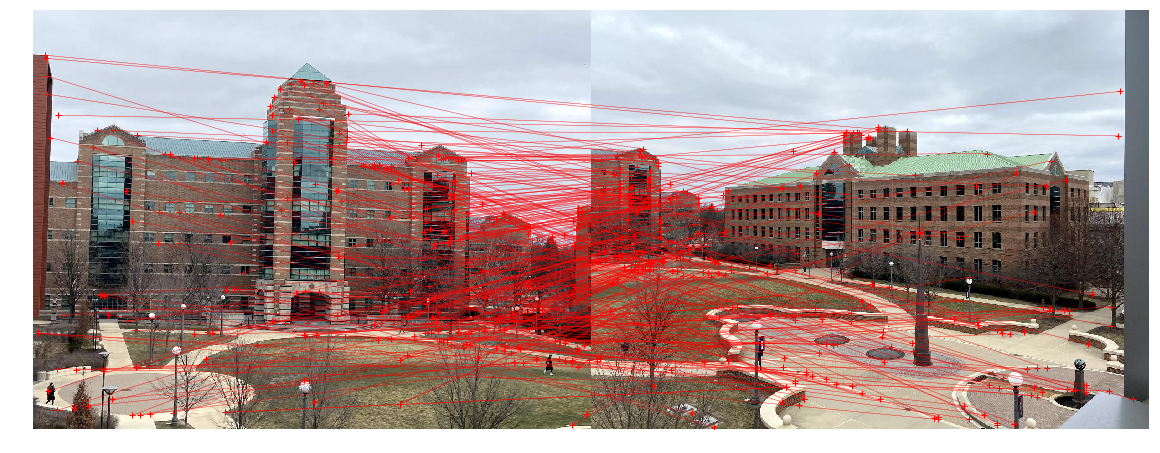

In [6]:
# part (c) compute and display the initial SIFT matching result
data = get_best_matches(img1, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.pdf', bbox_inches='tight')

Average residual: 1.0189492106520888
Number of inliers: 97


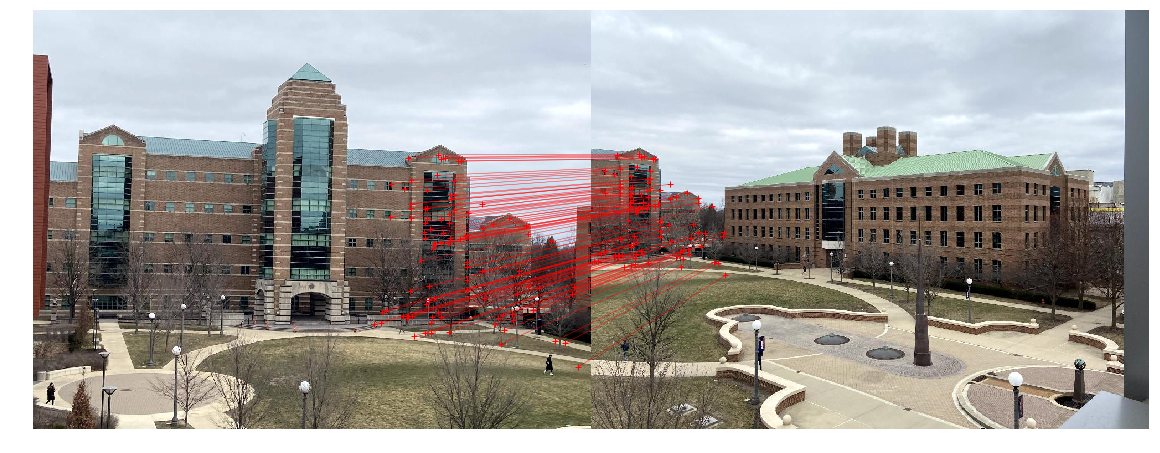

In [8]:
# part (d) performn RANSAC to get the homography and inliers, 
# display the inlier matching, report the average residual

max_inliers, best_model_errors, best_H = ransac(data, threshold=3, iterations=10000, num_samples=4)
print("Average residual:", np.average(best_model_errors))
print("Number of inliers:", len(max_inliers))
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, max_inliers)
fig.savefig('ransac_match.pdf', bbox_inches='tight')

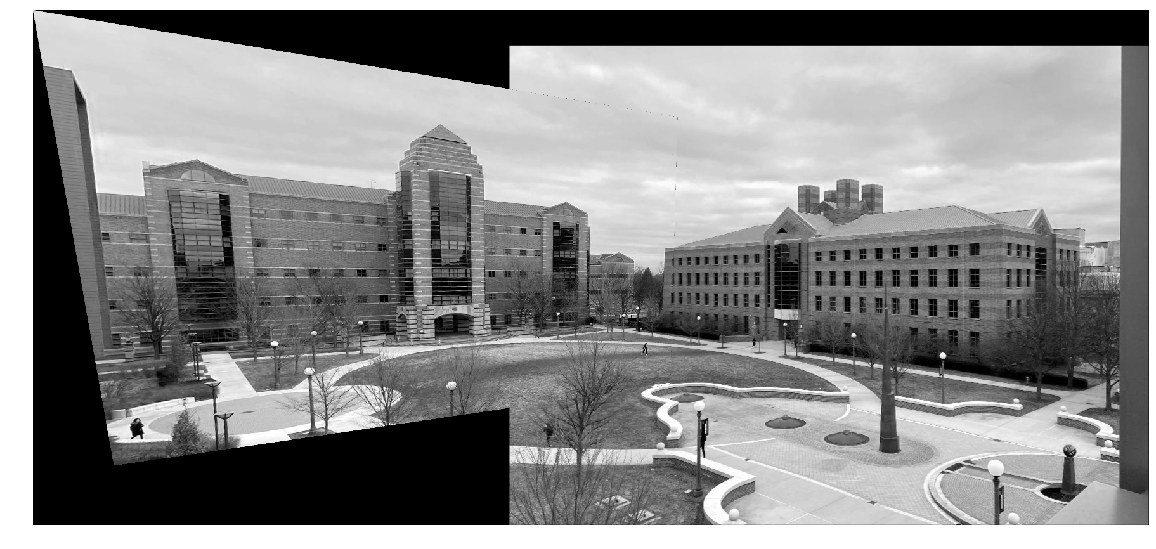

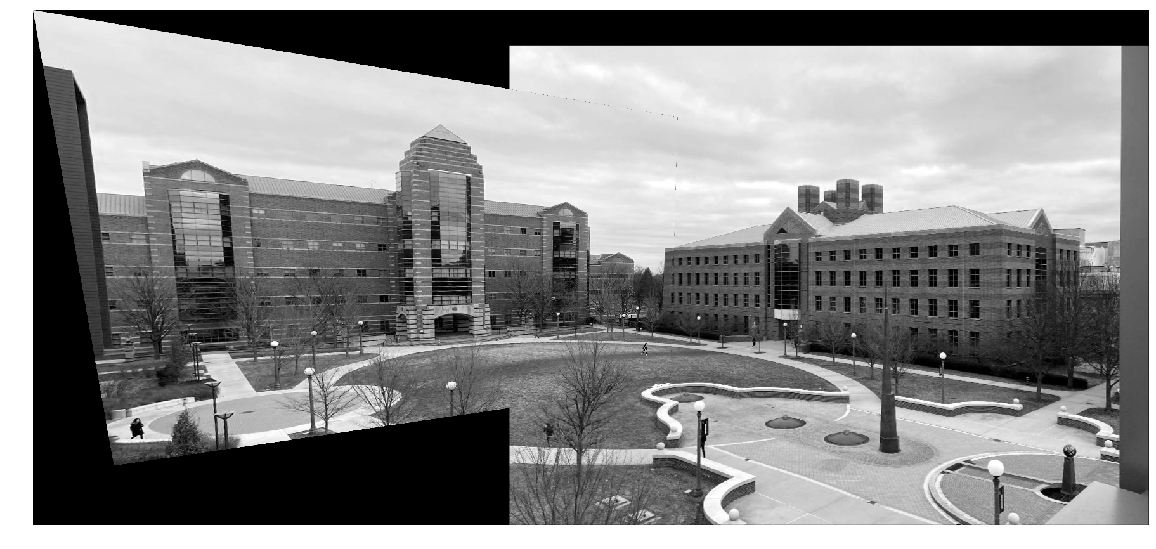

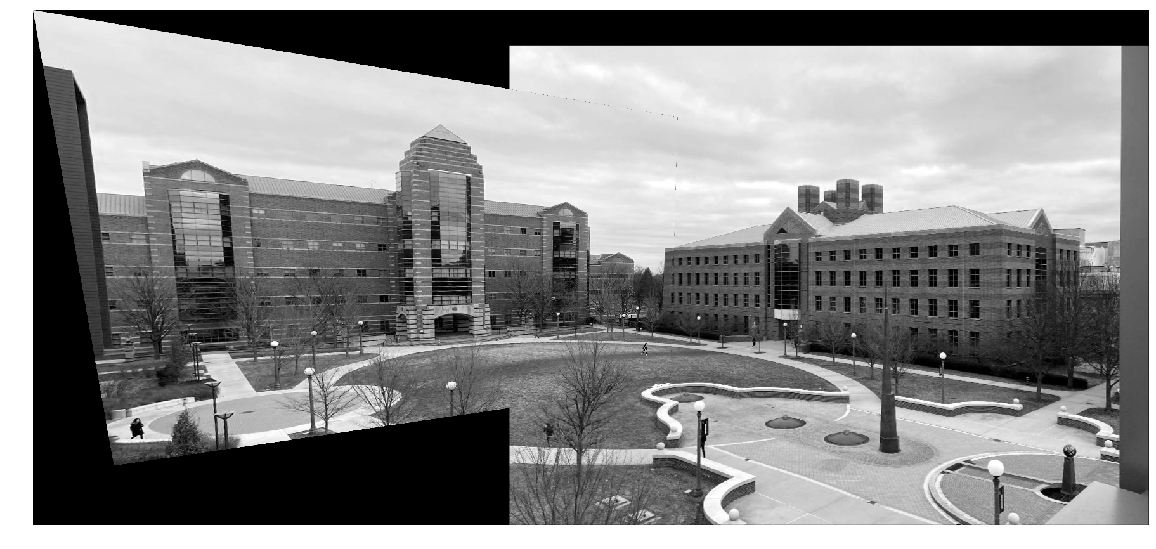

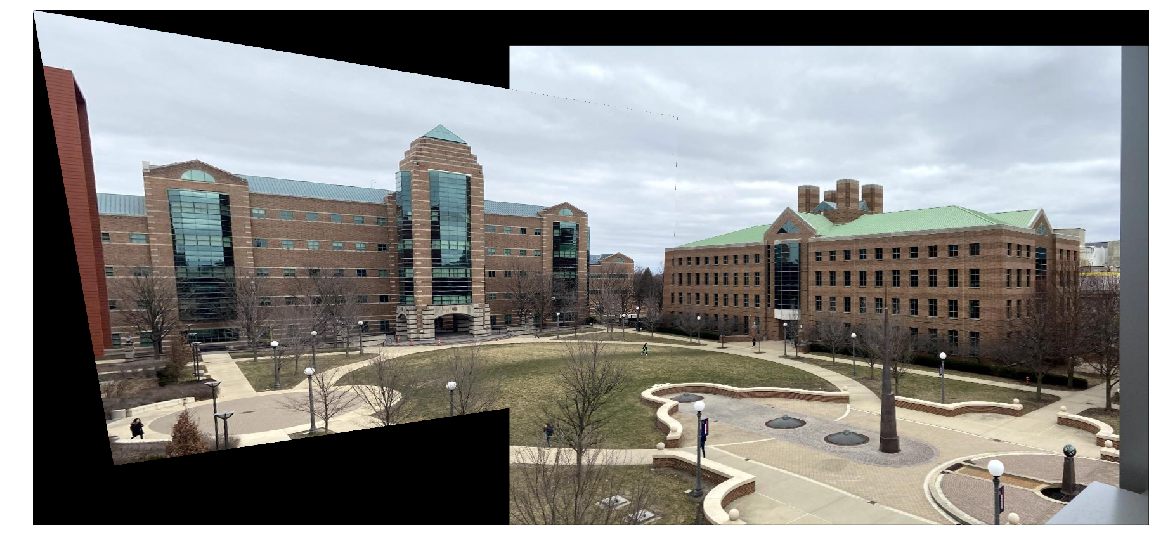

In [12]:
# part (e) warp images to stitch them together, 
# display and report the stitching results

# red
fig, ax = plt.subplots(figsize=(20,10))
warp_images(ax, img1[:,:,0], img2[:,:,0], best_H)
fig.savefig("sift_match_red.pdf", bbox_inches='tight')

# green
fig, ax = plt.subplots(figsize=(20,10))
warp_images(ax, img1[:,:,1], img2[:,:,1], best_H)
fig.savefig("sift_match_green.pdf", bbox_inches='tight')

# blue
fig, ax = plt.subplots(figsize=(20,10))
warp_images(ax, img1[:,:,1], img2[:,:,1], best_H)
fig.savefig("sift_match_blue.pdf", bbox_inches='tight')

# rgb
fig, ax = plt.subplots(figsize=(20,10))
warp_images(ax, img1, img2, best_H)
fig.savefig("sift_match_rgb.pdf", bbox_inches='tight')

# cv2.imwrite('stitched_images.jpg', im[:,:,::-1]*255., 
#             [int(cv2.IMWRITE_JPEG_QUALITY), 90])

In [14]:
# part (f) Extend your homography estimation to work on multiple images.
def multiple_images(path, num_images, name):
    img_prev = imread(path + '1.jpg')
    
    for i in range(2, num_images+1):
        img_cur = imread(path + str(i) + '.jpg')
        data = get_best_matches(img_prev, img_cur, 300)
        max_inliers, best_model_errors, best_H = ransac(data, threshold=3, iterations=1000, num_samples=4)
        fig, ax = plt.subplots(figsize=(20,10))
        img_prev = warp_images(ax, img_prev, img_cur, best_H)
        if i == num_images:
            fig.savefig(name+'.png', bbox_inches='tight')

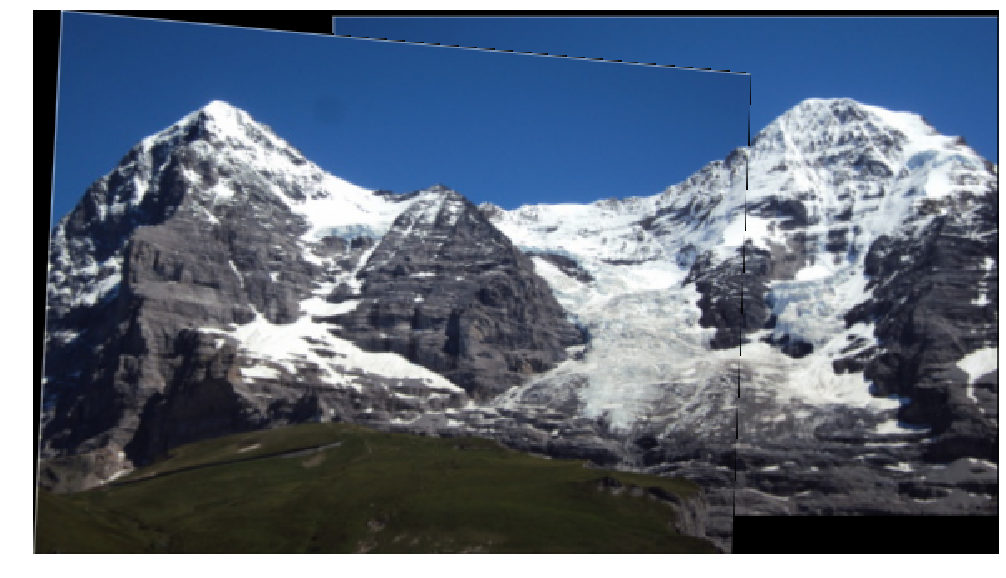

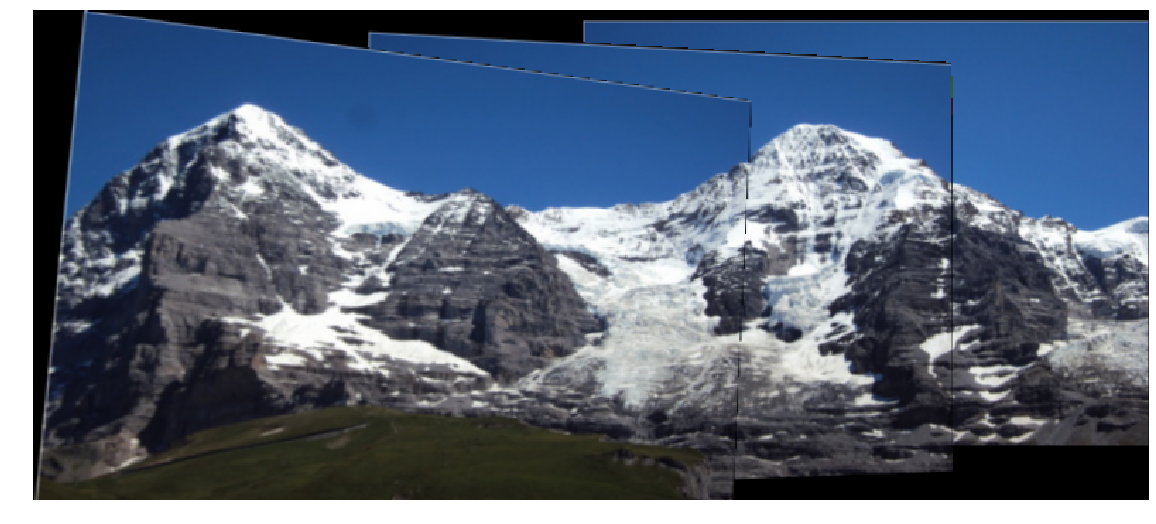

In [83]:
multiple_images('data/Q1/extra_credits/hill/', num_images=3, name='hill')

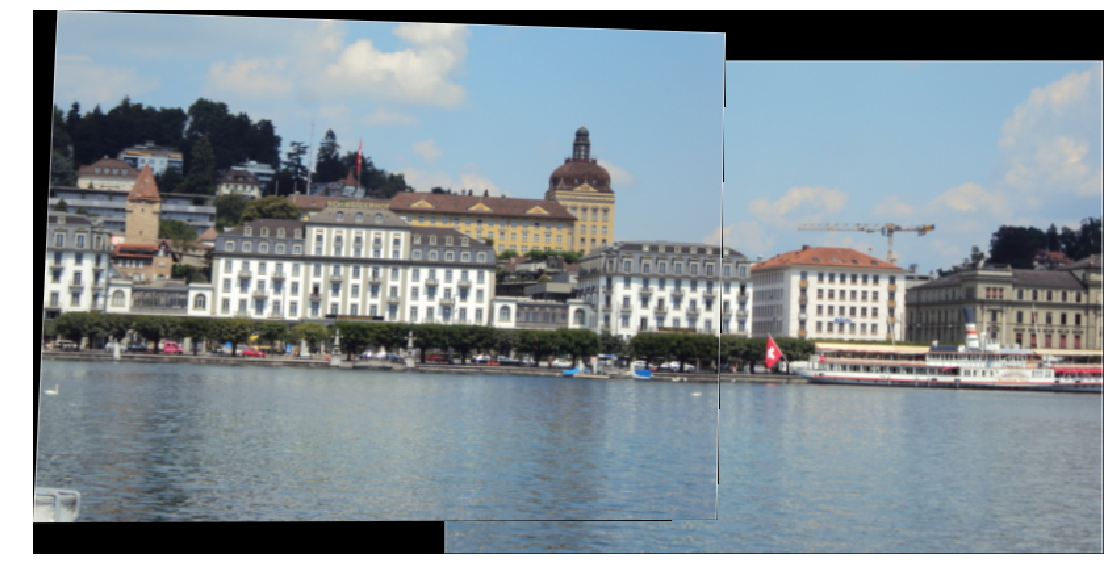

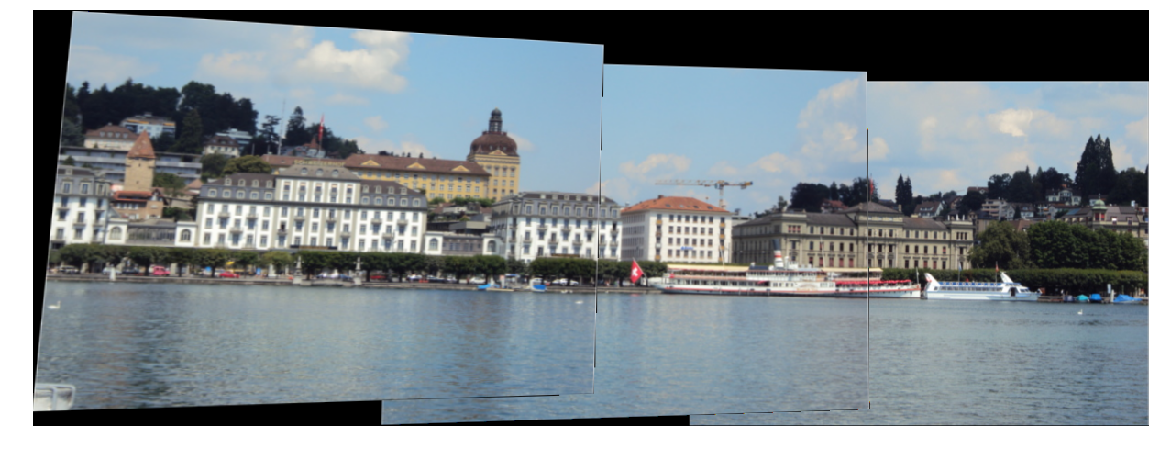

In [9]:
# multiple_images('data/Q1/extra_credits/ledge/', num_images=3, name='ledge')
multiple_images('data/Q1/extra_credits/pier/', num_images=3, name='pier')